In [29]:
import twint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import asyncio
import nest_asyncio
nest_asyncio.apply()
import pickle
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords

### CountVectorizing boroughs

In [30]:
# concatenating all manhattan searches

mn = pd.DataFrame(pd.read_pickle("../Data/mn1_tweets.pkl"))

for x in range(2, 7):
    mn = pd.concat([mn,pd.read_pickle("../Data/mn{}_tweets.pkl".format(x))])
    
# reading each borough's pandas df

bk = pd.DataFrame(pd.read_pickle("../Data/bk_tweets.pkl"))
qn = pd.DataFrame(pd.read_pickle("../Data/qn_tweets.pkl"))
bx = pd.DataFrame(pd.read_pickle("../Data/bx_tweets.pkl"))
si = pd.DataFrame(pd.read_pickle("../Data/si_tweets.pkl"))

boroughs = [bk, qn, bx, si, mn]

In [31]:
import nltk
from nltk.corpus import stopwords

blm_stopwords = ['www','http','https','https twitter','https twitter com','twitter',
                'pic twitter','pic twitter com','twitter com',
                'https www', 'https www instagram','instagram','instagram com',
                'www instagram','www instagram com','at the','in the','of the',
                'the protest','if you','this is','on the','to the','you re','carrd','co',
                'on','out','with','is','our','too','so','my','igshid','status',
                'like','to be','would','let','via','for the','even','still','and the','back',
                'many','way','make','said','is the','think','say','see','go','going','know','time',
                'get','http chng','chng','chng it','petition http','really','is not','you are',
                'via change','they are','much','we are','with the','want to','from the','they re','have to',
                'going to','the same','must','we re','it was','well','out of','are all','you can',
                'to do','will be','should be','start','saying','to get','com ca','in new','https youtu',
                'we can','over the','york https']


# select borough
blm_data = si

# filtering out tweets that got fewer than 1000 likes to make processing easier
# blm_data = blm_data[blm_data.nlikes>1000]

# countvectorizing blm tweets
vectorizer = CountVectorizer(ngram_range=(1,1))

X = vectorizer.fit_transform(blm_data['tweet'])

user_ids = list(blm_data['user_id'])

blm_countvec = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())

# build df with blm user_ids and countvectorized tweets
blm_countvec.insert(0, "user_id", user_ids, False) 

# import list of general stopwords
nltk_stopwords = stopwords.words()

# create list of stopwords found in the blm tweets
stopwords = list(set(blm_countvec.columns) & set(nltk_stopwords)) +list(set(blm_countvec.columns) & set(blm_stopwords))

# remove stopwords from countvectorized blm tweets
blm_countvec = blm_countvec.drop(stopwords,axis=1)

In [32]:
pd.options.display.max_rows = 4000

print('Number of tweets: '+str(blm_countvec.shape[0]))

# get 100 top keywords
top_blm_keywords = blm_countvec.iloc[:,1:].sum(axis=0).sort_values(ascending=False)[:100]
top_blm_keywords

Number of tweets: 744


police              405
protest             214
people              126
floyd               125
george              119
black               116
blm                  77
lives                66
matter               59
peaceful             55
change               54
officers             53
island               47
staten               45
justice              44
stop                 41
right                39
blacklivesmatter     37
death                36
us                   36
nyc                  34
need                 33
mayor                31
sign                 31
new                  30
today                30
officer              29
white                29
cops                 29
petition             28
minneapolis          27
shit                 26
force                26
law                  26
violence             25
protesters           25
murder               25
brutality            23
please               23
cop                  22
riot                 22
protests        

In [33]:
import re

# reading pickle files into pandas dataframes
blm_data = si

blm_tweets = blm_data['tweet']

# cleaning tweets - removing non-alphabetic characters and converting to lowercase
for n in range(blm_tweets.shape[0]):
    blm_tweets.iloc[n] = re.sub(r'[^\w]', ' ', blm_tweets.iloc[n]).split(' ')
    blm_tweets.iloc[n] = [i.lower() for i in blm_tweets.iloc[n]]

/Users/leekho/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [34]:
# extracting top keywords from tweets
blm_keywords = [[]]*blm_tweets.shape[0]
blm_tweets.iloc[0]

for n in range(blm_tweets.shape[0]):
    blm_keywords[n] = list(set(blm_tweets.iloc[n]) & set(list(top_blm_keywords.index)))

In [35]:
import itertools

# determining connections between keywords (i.e. seeing which keywords were used together)
blm_keyword_edges = []
for blm_keyword_list in blm_keywords:
    combos = itertools.combinations(blm_keyword_list, 2)
    blm_keyword_edges = blm_keyword_edges+list(combos)
    
len(blm_keyword_edges)

6490

In [36]:
# creating list of all keyword connections to determine weight of edges
for n in range(len(blm_keyword_edges)):
    blm_keyword_edges[n] = tuple(sorted(blm_keyword_edges[n]))
    
blm_keyword_edges[:5]

[('help', 'lives'),
 ('lives', 'riots'),
 ('george', 'lives'),
 ('lives', 'police'),
 ('help', 'riots')]

In [37]:
import collections

# counting up keyword connections to determine weight of edges
blm_counter=collections.Counter(blm_keyword_edges)

# filtering out edges with weights of less than 10 (for bk, less than 20)
blm_counter_fil = {key:val for key, val in blm_counter.items() if val >10}

# getting final node list
all_blm_keywords=list(set(list(sum(list(blm_counter_fil.keys()), ()))))
len(all_blm_keywords)

49

In [38]:
# creating list of weights and list of nodes for graph
blm_weights = list(blm_counter_fil.values())
blm_edges = list(blm_counter_fil.keys())

collections.Counter(blm_weights)

Counter({13: 5,
         16: 6,
         18: 8,
         42: 1,
         21: 5,
         12: 7,
         17: 19,
         40: 2,
         45: 1,
         41: 2,
         22: 5,
         15: 4,
         11: 11,
         14: 8,
         30: 1,
         55: 1,
         20: 4,
         23: 1,
         19: 1,
         102: 1,
         24: 4,
         27: 4,
         29: 2})

/Users/leekho/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


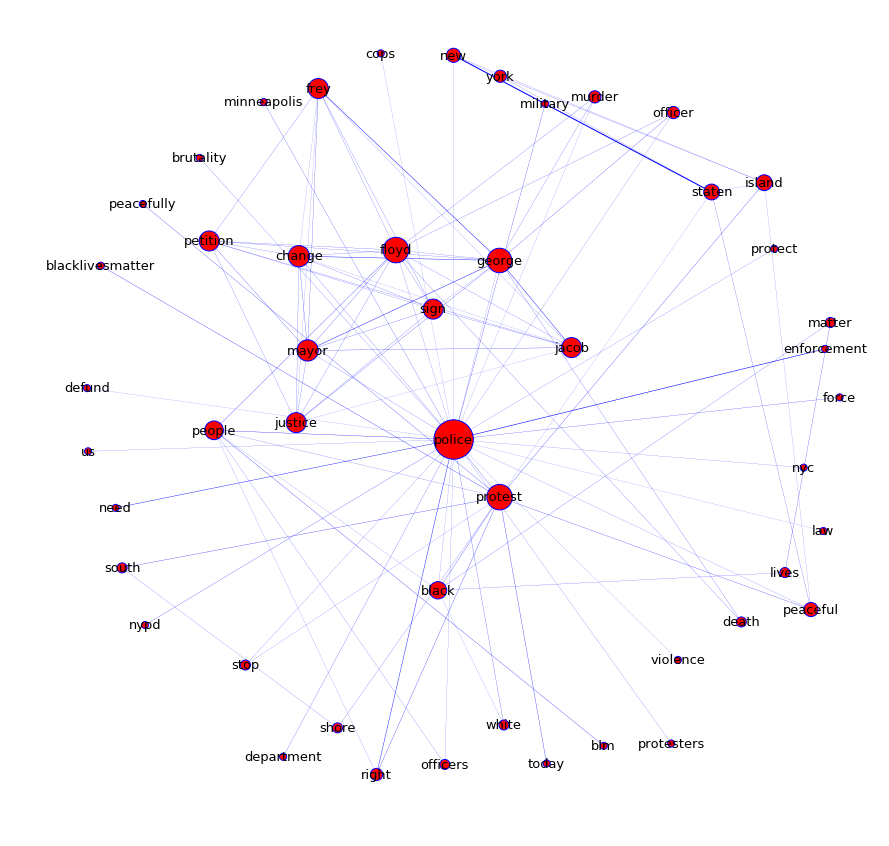

In [39]:
import matplotlib.pyplot as plt
import networkx as nx
import graphviz

G = nx.Graph()

for n in range(len(blm_edges)):
    G.add_edge(blm_edges[n][0], blm_edges[n][1], weight=blm_weights[n])
    
d = dict(G.degree)

# graph layout type
pos = nx.spring_layout(G,k=4)

# nodes
nx.draw_networkx_nodes(G, pos, node_color = 'r', node_size=[v * 50 for v in d.values()]).set_edgecolor('b')

# edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges,edge_color = 'b',width=[v * 0.01 for v in blm_counter_fil.values()])

# labels
nx.draw_networkx_labels(G, pos, font_size=13, font_family='sans-serif')

fig = plt.figure(1,figsize=(15,15))
fig.set_figheight(15)
fig.set_figwidth(15)
plt.axis('off')
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=3.)

    pos_nodes = _position_nodes(g, partition, scale=1.)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph,k=10,iterations=20)
        #pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos

def test():
    # to install networkx 2.0 compatible version of python-louvain use:
    # pip install -U git+https://github.com/taynaud/python-louvain.git@networkx2
    from community import community_louvain

    g = nx.Graph()

    for n in range(len(blm_edges)):
        g.add_edge(blm_edges[n][0], blm_edges[n][1], weight=blm_weights[n])
        
    partition = community_louvain.best_partition(g)
    
    for key, value in partition.items():
        if partition[key] == 0:
            partition[key] = 'r'
        elif partition[key] == 1:
            partition[key] = 'g'
        elif partition[key] == 2:
            partition[key] = 'y'
        else:
            partition[key] = 'w'
    
    pos = community_layout(g, partition)
    
    # nodes
    nx.draw_networkx_nodes(g, pos, node_color = list(partition.values()), node_size=[v * 50 for v in d.values()]).set_edgecolor('b')

    # edges
    nx.draw_networkx_edges(g, pos, edgelist=G.edges,edge_color = 'b',width=[v * 0.005 for v in blm_counter_fil.values()])
    
    # labels
    nx.draw_networkx_labels(g, pos, font_size=10, font_family='sans-serif')
    
    fig = plt.figure(1,figsize=(15,15))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    plt.axis('off')
    plt.show()
    return

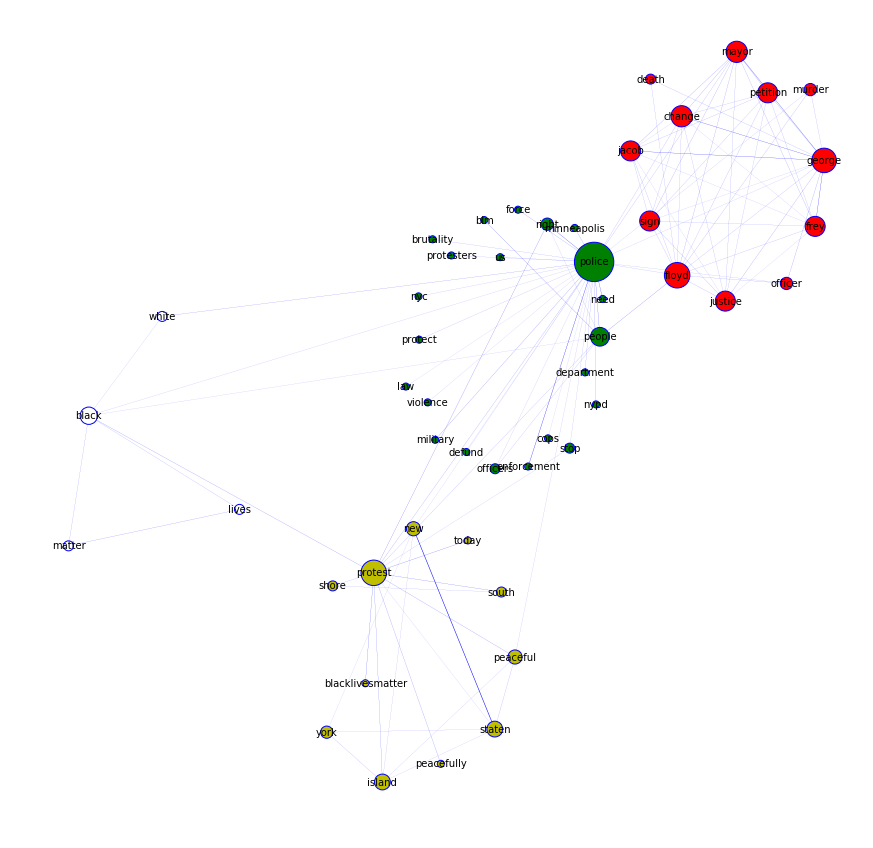

In [41]:
test()

### Creating JSON file

In [42]:
from community import community_louvain

search_terms = ['blm', 'black lives matter', 'black','lives','matter','police', 'protest', 'riot','george floyd','george','floyd']

g = nx.Graph()

for n in range(len(blm_edges)):
    g.add_edge(blm_edges[n][0], blm_edges[n][1], weight=blm_weights[n])

# creating groups using the Louvain method
partition = community_louvain.best_partition(g)

print("blm edges")
print(blm_edges[:5])

def get_index(keyword):
    return(all_blm_keywords.index(keyword)+1)

blm_source = [int(i) for i in [get_index(edge[0]) for edge in blm_edges]]

blm_target = [int(i) for i in [get_index(edge[1]) for edge in blm_edges]]

print("blm edge weights")
print(blm_weights[:5])

print(all_blm_keywords)

print("blm node keywords")
all_blm_keywords = list(d.keys())
print(all_blm_keywords[:])

print("blm node weights")
keyword_weight = [str(i) for i in list(d.values())]
print(keyword_weight[:5])

print("blm node id_num")
id_num = [i+1 for i in range(len(all_blm_keywords))]
print(id_num[:5])

print("blm node group")
group = [str(i) for i in list(partition.values())]

search_term_ind = []
for i in search_terms:
    try:
        search_term_ind.append(all_blm_keywords.index(i))
    except:
        pass

for j in search_term_ind:
    group[j] = '10'

print(group[:5])

blm edges
[('george', 'police'), ('new', 'york'), ('police', 'protect'), ('officers', 'police'), ('law', 'police')]
blm edge weights
[13, 16, 18, 42, 21]
['black', 'officers', 'nyc', 'matter', 'enforcement', 'south', 'blm', 'police', 'people', 'mayor', 'protesters', 'right', 'need', 'staten', 'shore', 'military', 'george', 'lives', 'peacefully', 'today', 'sign', 'violence', 'department', 'stop', 'peaceful', 'protect', 'officer', 'defund', 'york', 'law', 'change', 'jacob', 'brutality', 'justice', 'murder', 'white', 'floyd', 'force', 'blacklivesmatter', 'nypd', 'petition', 'frey', 'protest', 'cops', 'island', 'minneapolis', 'death', 'new', 'us']
blm node keywords
['george', 'police', 'new', 'york', 'protect', 'officers', 'law', 'black', 'white', 'defund', 'matter', 'lives', 'need', 'cops', 'protest', 'right', 'blacklivesmatter', 'island', 'staten', 'officer', 'nyc', 'people', 'peaceful', 'enforcement', 'brutality', 'violence', 'south', 'shore', 'protesters', 'force', 'minneapolis', 'mayo

In [87]:
import json

# creating json file to feed into D3 graph
# NOTE: after creating json file, you will have to do additional cleaning to get it into the correct
# format to feed into the D3 graph script
node_data = {'id':id_num,'name':all_blm_keywords,'value':keyword_weight,'group':group}
node_df = pd.DataFrame(data=node_data)

edge_data = {'source':blm_source,'target':blm_target,'weight':blm_weights}
edge_df = pd.DataFrame(data=edge_data)

print(edge_df.head())

node_json = json.loads(node_df.to_json(orient='records'))
edge_json = json.loads(edge_df.to_json(orient='records'))

with open('si_graph_uni_3.json', 'w') as f:
    json.dump({'nodes':node_json,'links':edge_json}, f)

   source  target  weight
0      17       8      13
1      48      29      16
2       8      26      18
3       2       8      42
4      30       8      21
